# MetaboBlend

## Example data

For this example, we load D-Glucose (HMDB0000122) before generating a database of its
substructures; MetaboBlend leverages substructures of known endogenous compounds to
generate candidate structures for a given molecular composition and exact mass. We
can additionally annotate MSn spectra in order to rank candidate lists.

In [5]:
# standard imports
import os
import shutil

# rdkit - manipulation of molecules
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

# metaboblend imports
from metaboblend.build_structures.annotate import generate_structures, annotate_msn

# extract test data
test_data = os.path.realpath(os.path.join("..", "tests", "test_data"))
notebook_data = os.path.realpath(os.path.join("notebook_data"))

shutil.copytree(test_data, notebook_data)

'C:\\Users\\jackg\\OneDrive\\Documents\\Work\\Final_Year_2019-2020\\LCMS_Dissertation\\Metaboverse\\metaboblend\\notebooks\\notebook_data'

## Database generation

MetaboBlend requires a connectivity and substructure database in order to
propose candidate structures. Combinations of substructures are considered
by MetaboBlend to propose candidate structures for a metabolite of interest.
A standard connectivity database is bundled with the package and a small
substructure database has been pre-generated for this example.

## Standard structure generation

Candidate structures can be generated for a given molecular formula and
exact mass from the generated databases. Since this method doesn't use
MS/MS information, many unique structures can be generated and candidates
are not assigned a relative score.

The function yields a set of smiles for each compound in ms_data
(in this case, only HMDB0000122). After extracting smiles, RDKit can be
used to visualise generated structures.

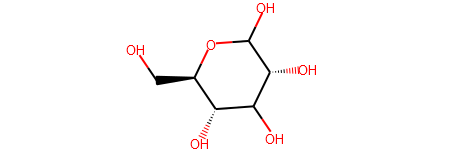

In [7]:
ms_data = {"HMDB0000122": {"mc": [6, 12, 0, 6, 0, 0], "exact_mass": 180.063388116}}

struct_generator = generate_structures(ms_data,
                                       heavy_atoms=range(2, 13), max_valence=6,
                                       max_atoms_available=2, max_n_substructures=3,
                                       path_connectivity_db=os.path.join(notebook_data, "connectivity.sqlite"),
                                       path_substructure_db=os.path.join(notebook_data, "substructures.sqlite"))

# convert generated sets of smiles to rdkit.Chem.Mol objects
generated_mols = [Chem.MolFromSmiles(smiles) for i, smiles in enumerate(list(struct_generator)[0])]
generated_mols[0]

## MS/MS guided structure generation

MSn spectra provide a means of scoring candidates and limiting
the generation of unrealistic structures. A list of neutral
masses can be provided with the molecular composition and exact
mass of a metabolite of interest to inform the annotation process.
These masses may have been calculated from the fragment ions of
an MS2 spectrum; in this example, the masses of known substructures
have been chosen.


Total structures generated: 47
Number of structures generated by all peaks: 0
2


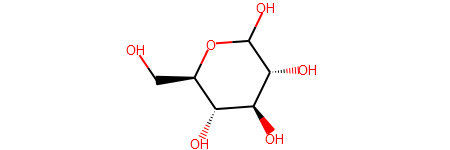

In [8]:
ms_data = {"HMDB0000122": {"mc": [6, 12, 0, 6, 0, 0], "exact_mass": 180.063388116,
                           "prescribed_masses": [46.0055, 60.0211, 73.029]}}  #

annotation_generator = annotate_msn(ms_data, heavy_atoms=range(2, 13), max_valence=6,
                                    max_atoms_available=2, max_n_substructures=3, ppm=5,
                                    path_connectivity_db=os.path.join(notebook_data, "connectivity.sqlite"),
                                    path_substructure_db=os.path.join(notebook_data, "substructures.sqlite"))

annotated_structures = list(annotation_generator)[0]
print("Total structures generated: " + str(len(annotated_structures)))
print("Number of structures generated by all peaks: " + str(list(annotated_structures.values()).count(3)))

print(annotated_structures["OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O"])
Chem.MolFromSmiles("OC[C@H]1OC(O)[C@H](O)[C@@H](O)[C@@H]1O")